Implement a prediction model using Support Vector Machine to predict the QoT Quality of Transmission in terms of the OSNR Optical Signal to Noise Ratio of an optical lightpath. 

This exercise is based on the research paper Active Wavelength Load as a Feature for QoT Estimation Based on Support Vector Machine. Please refer to the paper for the description of the data.


### IMPORT LIBRARIES

In [1]:
import numpy as np 
import pandas as pd 
import plot_statistics as ps 
from sklearn import svm, metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import file_reader as fr

### LOADING THE DATA

The dataset is already split respecting a 80/20 ratio for training and testing set respectively. Run the cell below.

In [2]:
training_set_file = 'dataset/trainingset.csv'
testing_set_file = 'dataset/testset.csv'

In [3]:
X_train, y_train = fr.FileReader.read_array_three_class(fr.FileReader(), training_set_file)

X_test, y_test = fr.FileReader.read_array_three_class(fr.FileReader(), testing_set_file)

Class A samples : 3326 
Class B samples : 1196 
Class C samples : 1396 
Class D samples : 1564
Class A samples : 594 
Class B samples : 251 
Class C samples : 307 
Class D samples : 224


### BUILDING SVM MODEL

Creating a SVC with hyperparameters C=10 and gamma = 0.0001 and radial basis functuib as kernel function

In [4]:
parameters = {'kernel' : ['rbf'], 'C':[10], 'gamma':[0.0001]}

svc = svm.SVC()
print(svc)

SVC()


In [5]:
classifier = GridSearchCV(svc, parameters, n_jobs=10, cv=5)
print(classifier)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=10,
             param_grid={'C': [10], 'gamma': [0.0001], 'kernel': ['rbf']})


### FITTING THE DATA INTO THE MODEL

In [6]:
y_train = np.argmax(y_train, axis=1)

y_score = classifier.fit(X_train, y_train).decision_function(X_test)

print(y_score)

[[ 3.23060216  2.12546475  1.00666891 -0.2471719 ]
 [ 3.27510302  2.19662338  0.8760895  -0.28260517]
 [-0.26917961  0.94144932  2.2429941   3.21074543]
 ...
 [ 3.20211638  0.98387441  2.18434857 -0.24389233]
 [-0.15226489  1.96009516  3.18632254  0.92496697]
 [-0.28178806  0.82737777  2.24570189  3.26296698]]


### EVALUATE THE PERFORMANCE

let's evaluate how well it does for predicting and classifying the unestablished lightpaths from the testing dataset. With Scikit-learn there are multiple metrics you can use to do so, in this example you will be using the Receiver Operating Characteristic (ROC) curve and the Confusion Matrix. Also, you will be generating a classification report with the precision), recall and F1-score of your classifier for the multiple OSNR-classes.

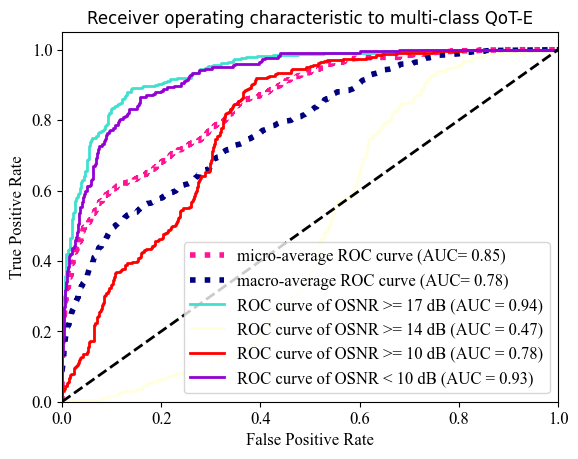

Normalized Confusion Matrix
[[0.91919192 0.01515152 0.05555556 0.01010101]
 [0.58167331 0.00398406 0.35856574 0.05577689]
 [0.14983713 0.00977199 0.39739414 0.44299674]
 [0.03125    0.01339286 0.125      0.83035714]]


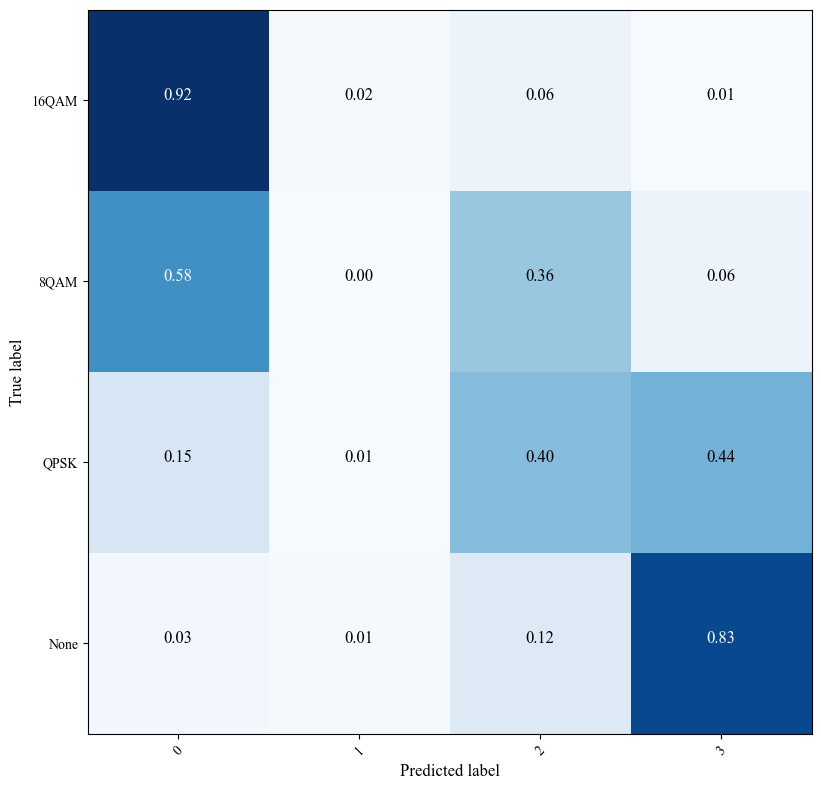

Classification report for the classifier: 
GridSearchCV(cv=5, estimator=SVC(), n_jobs=10,
             param_grid={'C': [10], 'gamma': [0.0001], 'kernel': ['rbf']}) 
              precision    recall  f1-score   support

           0       0.73      0.92      0.82       594
           1       0.06      0.00      0.01       251
           2       0.45      0.40      0.42       307
           3       0.54      0.83      0.66       224

    accuracy                           0.62      1376
   macro avg       0.45      0.54      0.48      1376
weighted avg       0.52      0.62      0.55      1376



In [7]:
ps_obj = ps.PlotStats()

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

#Plot ROC_Curve
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ps_obj.plot_roc_curve_multi(fpr, tpr, roc_auc, n_classes)

#Confusion matrix
predicted = classifier.predict(X_test)
y_test_rs = np.argmax(y_test, axis=1)

cnf_matrix = metrics.confusion_matrix(y_test_rs, predicted)

ps_obj.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3], normalize=True, title="Confusion Matrix QoT-E")

print(f"Classification report for the classifier: \n{classifier} \n{metrics.classification_report(y_test_rs, predicted)}")
